# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import math
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as img
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline

# Exploring data

In [2]:
print('Classes:')
!ls /home/javier/Documents/dsub/20220408CAPSTONE_CAPSULE/20220408CAPSULE_DATA/splits/splitslowres/split_0

Classes:
 Angiectasia   Erythematous	   Lymphangiectasia  'Reduced Mucosal View'
 Blood	      'Foreign Bodies'	   Normal	      Ulcer
 Erosion      'Ileo-cecal valve'   Pylorus


dimensions of photo: (168, 168, 3)


Text(0.5, 1.0, 'Image test')

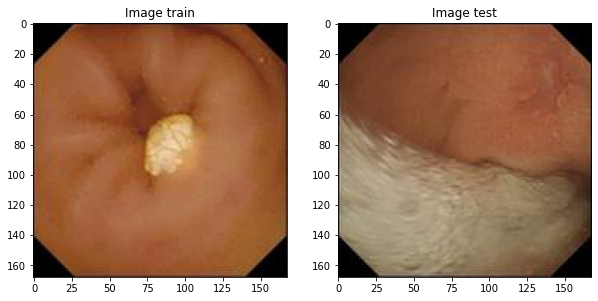

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#img_pred = plt.imread('/home/javier/Documents/dsub/20220408CAPSTONE_CAPSULE/20220408CAPSULE_DATA/splits/splitslowres/split_0/Lymphangiectasia/home/javier/Documents/dsub/20220408CAPSTONE_CAPSULE/20220424intelimageclassification/dataset/seg_pred/19527.jpg')
img_train = plt.imread('/home/javier/Documents/dsub/20220408CAPSTONE_CAPSULE/20220408CAPSULE_DATA/splits/splitslowres/split_0/Lymphangiectasia/64440803f87b4843_17833.jpg')
img_test = plt.imread('/home/javier/Documents/dsub/20220408CAPSTONE_CAPSULE/20220408CAPSULE_DATA/splits/splitslowres/split_1/Erosion/dac1e27f7e4d4ef5_2397.jpg')
print(f'dimensions of photo: {img_train.shape}')
#ax[0].imshow(img_pred)
ax[0].imshow(img_train)
ax[1].imshow(img_test)
#ax[0].set_title('Image pred')
ax[0].set_title('Image train')
ax[1].set_title('Image test')

# DataLoader

In [4]:
class MyDataset(datasets.ImageFolder):
    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target, path

In [5]:
train_transforms = transforms.Compose([
                                       transforms.RandomHorizontalFlip(),
                                       transforms.Resize((224, 224)),
                                       transforms.RandomRotation(20),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
                                      transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])
])

valid_size = 0.2

trainset = MyDataset('/home/javier/Documents/dsub/20220408CAPSTONE_CAPSULE/20220408CAPSULE_DATA/splits/splitslowres/split_0', transform=train_transforms)
testset = MyDataset('/home/javier/Documents/dsub/20220408CAPSTONE_CAPSULE/20220408CAPSULE_DATA/splits/splitslowres/split_1', transform=test_transforms)

num_test = len(testset)
indices = list(range(num_test))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_test))
test_idx, valid_idx = indices[split:], indices[:split]

test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=12)
validloader = torch.utils.data.DataLoader(testset, batch_size=32, num_workers=12, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, sampler=test_sampler, num_workers=12)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Length of training dataset: 23061
Length of validation dataset: 4820.0
Length of test dataset: 19280.0
Size of images batch: torch.Size([32, 3, 224, 224])
tensor(4)


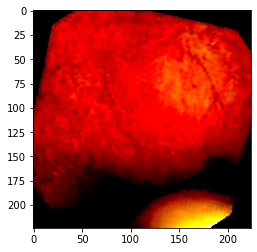

In [6]:
images, labels, path = next(iter(trainloader))
ind = 0
print(f'Length of training dataset: {len(trainset)}')
print(f'Length of validation dataset: {valid_size*len(testset)}')
print(f'Length of test dataset: {(1-valid_size)*len(testset)}')
print(f'Size of images batch: {images.shape}')

image = np.transpose(images[0].numpy(), (1, 2, 0))
plt.imshow(image)
print(labels[ind])

# [1] Refining Model (ResNet50)

In [9]:
model = models.resnet50(pretrained=True)

In [10]:
# Freeze layers here
for param in model.parameters():
    param.requires_grad = False

In [11]:
model.fc = nn.Sequential(nn.Linear(2048, 1024),
                          nn.ReLU(),
                          nn.Linear(1024, 11),
                         nn.LogSoftmax(dim=1))

In [12]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Training

In [12]:
def train(model, dataloaders, criterion, optimizer, scheduler, use_gpu=True, epochs=5, min_loss=np.Inf, saveto='model.pt'):
    best_weights = model.state_dict()
    min_loss = min_loss

    for epoch in range(epochs):
        print(f'\nEpoch{epoch+1}/{epochs}')
        print('--------------------')
        for phase in ['train', 'eval']:
            if(phase=='train'):
                model.train()
            else:
                model.eval()
            running_loss = 0.0

            for data, target, _ in tqdm(dataloaders[phase]):
                torch.cuda.empty_cache()
                data, target = data.cuda(), target.cuda()
                optimizer.zero_grad()
                output = model(data)
                if(type(output)==tuple):
                    output, _ = output
                loss = criterion(output, target)

                if(phase=='train'):
                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.item() * data.size(0)
            
            if(phase=='eval'):
                epoch_loss = running_loss/(valid_size*len(testset))
            else:
                epoch_loss = running_loss/len(trainset)

            print(f'\nLoss in {phase} phase: {epoch_loss}')

            if(phase=='eval' and min_loss>epoch_loss):
                print('\nSaving new model...')
                min_loss = epoch_loss
                best_weights = model.state_dict()
                torch.save(model, saveto)
        scheduler.step(epoch_loss)
        for param in optimizer.param_groups:
            print('Learning rate:', param['lr'])
        
    print(f'\nTraining Complete!\nMinimum Loss: {min_loss}')

    model.load_state_dict(best_weights)
    return model

In [14]:
model = train(model, {'train': trainloader, 'eval': validloader}, criterion, optimizer, scheduler, saveto='resnet50.pt')


Epoch1/5
--------------------


  0%|          | 0/721 [00:00<?, ?it/s]


Loss in train phase: 0.6161703316322055


  0%|          | 0/151 [00:00<?, ?it/s]


Loss in eval phase: 1.1047856054860032

Saving new model...
Learning rate: 0.001

Epoch2/5
--------------------


  0%|          | 0/721 [00:00<?, ?it/s]


Loss in train phase: 0.39842563833968503


  0%|          | 0/151 [00:00<?, ?it/s]


Loss in eval phase: 1.2191537008245952
Learning rate: 0.001

Epoch3/5
--------------------


  0%|          | 0/721 [00:00<?, ?it/s]


Loss in train phase: 0.3210470687652429


  0%|          | 0/151 [01:00<?, ?it/s]


Loss in eval phase: 1.4054406392623775
Learning rate: 0.001

Epoch4/5
--------------------


  0%|          | 0/721 [00:00<?, ?it/s]


Loss in train phase: 0.2715515875531


  0%|          | 0/151 [00:00<?, ?it/s]


Loss in eval phase: 1.3233557867311343
Learning rate: 0.0005

Epoch5/5
--------------------


  0%|          | 0/721 [00:00<?, ?it/s]


Loss in train phase: 0.20209827266879377


  0%|          | 0/151 [01:00<?, ?it/s]


Loss in eval phase: 1.5456804423906
Learning rate: 0.0005

Training Complete!
Minimum Loss: 1.1047856054860032


In [ ]:
# model = torch.load('resnet50.pt')

## Inference

In [15]:
def getAccuracy(dataloader):
    model.eval()
    test_loss = 0
    running_corrects = 0
    for data, target, path in tqdm(dataloader):
        data, target = data.cuda(), target.cuda()
        output = model(data)

        _, preds = torch.max(output.data, 1)

        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)
        running_corrects += torch.sum(preds == target.data).item()

    print(test_loss/len(dataloader.dataset))
    print('Correct labels:', running_corrects, '/', len(dataloader.dataset))
    print('Correctness score:', running_corrects/len(dataloader.dataset))

### Making a dataloader with whole test dataset

In [16]:
fulltestloader = torch.utils.data.DataLoader(testset, batch_size=32, num_workers=12)

### Getting accuracies

In [17]:
print('Accuracy for valid+test set')
getAccuracy(fulltestloader)
print('Accuracy for test set')
getAccuracy(testloader)
print('Accuracy for train set')
getAccuracy(trainloader)

Accuracy for valid+test set


  0%|          | 0/754 [00:00<?, ?it/s]

1.53361060632215
Correct labels: 17844 / 24100
Correctness score: 0.7404149377593361
Accuracy for test set


  0%|          | 0/603 [01:00<?, ?it/s]

1.2244745093064684
Correct labels: 14287 / 24100
Correctness score: 0.5928215767634855
Accuracy for train set


  0%|          | 0/721 [00:00<?, ?it/s]

0.18553145240348892
Correct labels: 21661 / 23061
Correctness score: 0.93929144442999


# [2] Driving model (DenseNet-161)

In [7]:
model = models.densenet161(pretrained=True)

In [8]:
for param in model.parameters():
  param.requires_grad = False

In [9]:
for param in (model.features.denseblock3).parameters():
  param.requires_grad = True
for param in (model.features.denseblock4).parameters():
  param.requires_grad = True

In [10]:
model.classifier = nn.Sequential(nn.Linear(2208, 1024),
                                nn.ReLU(),
                                nn.Dropout(),
                                nn.Linear(1024, 11),
                                nn.LogSoftmax(dim=1))

In [11]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
model.cuda()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [13]:
model = train(model, {'train': trainloader, 'eval': validloader}, criterion, optimizer, scheduler, saveto='densenet161.pt')


Epoch1/5
--------------------


  0%|          | 0/721 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 12.00 MiB (GPU 0; 3.94 GiB total capacity; 2.92 GiB already allocated; 11.81 MiB free; 2.98 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Inference

In [15]:
def getAccuracy(dataloader):
    model.eval()
    test_loss = 0
    running_corrects = 0
    for data, target, path in tqdm(dataloader):
        data, target = data.cuda(), target.cuda()
        output = model(data)

        _, preds = torch.max(output.data, 1)

        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)
        running_corrects += torch.sum(preds == target.data).item()

    print(test_loss/len(dataloader.dataset))
    print('Correct labels:', running_corrects, '/', len(dataloader.dataset))
    print('Correctness score:', running_corrects/len(dataloader.dataset))

### Making a dataloader with whole test dataset

In [16]:
fulltestloader = torch.utils.data.DataLoader(testset, batch_size=32, num_workers=12)

### Getting accuracies

In [17]:
print('Accuracy for valid+test set')
getAccuracy(fulltestloader)
print('Accuracy for test set')
getAccuracy(testloader)
print('Accuracy for train set')
getAccuracy(trainloader)

Accuracy for valid+test set


100%|████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.58it/s]


0.281120407362779
Correct labels: 2677 / 3000
Correctness score: 0.8923333333333333
Accuracy for test set


100%|████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:16<00:00,  4.52it/s]


0.22981999532381694
Correct labels: 2133 / 3000
Correctness score: 0.711
Accuracy for train set


100%|██████████████████████████████████████████████████████████████████████████████████████████| 439/439 [01:35<00:00,  4.62it/s]

0.2657753554218869
Correct labels: 12645 / 14034
Correctness score: 0.9010260795211629


# Save model to Drive

In [ ]:
!cp densenet161.pt /content/drive/My\ Drive/intelmodel.pt

# Try out your own image (Demo)

## Dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from PIL import Image
from torchvision import transforms, models
%matplotlib inline

## Upload model weights and image

In [ ]:
from google.colab import files
files.upload()

In [ ]:
transform = transforms.Compose([
                                      transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])
])

## Evaluate results

In [ ]:
class GetProbs:
    def __init__(self, modelpath):
        self.model = torch.load(modelpath).cpu()
    
    def __call__(self, imgpath, plot=True):
        self.model.eval()
        img = Image.open(imgpath)
        preds = self.model(torch.unsqueeze(transform(img), 0))
        x = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
        if(plot):
            fig, ax = plt.subplots(1, 2, figsize=(12, 6))
            ax[0].imshow(img)
            ax[0].set_title('Original image')
            ax[1].set_title('Predictions')
            ax[1].set_ylabel('Percentage')
            ax[1].set_xlabel('Labels')
            prob = torch.exp(preds)
            prob = torch.div(prob, torch.sum(prob))
            prob = prob.detach().numpy()[0]
            sns.barplot(x=x, y=prob*100, ax=ax[1])
        else:
            pred = x[(torch.max(preds, dim=1))[1].item()]
            return pred

In [ ]:
get_probs = GetProbs('drive/My Drive/intelmodel.pt')
get_probs('seg_pred/1003.jpg')

# To get csv for seg_pred folder

In [ ]:
preds = []

for f in tqdm(os.listdir('seg_pred')):
    preds.append([f[:-4], get_probs('seg_pred/'+f, plot=False)])

In [ ]:
df = pd.DataFrame(data=preds, columns=['ID', 'Class'])

In [ ]:
df = df.sort_values('ID')

In [ ]:
df.to_csv('preds.csv', index=False)